In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


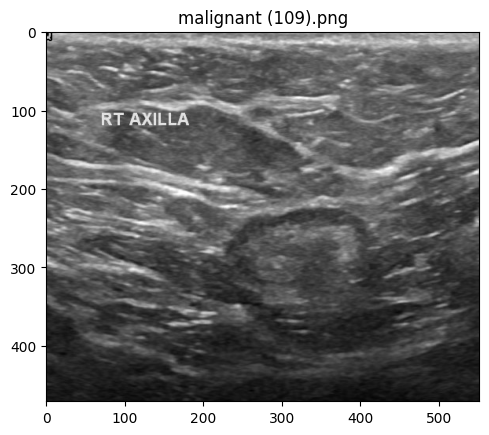

Image: malignant (109).png, Size: (552, 471), Mode: RGB


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = '/content/drive/MyDrive/CNPRM Workshop/Dataset_BUSI_with_GT/malignant'

# List all files in the directory
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]


for image_file in image_files:
    try:
      image_path = os.path.join(image_directory, image_file)
      img = Image.open(image_path)
      plt.imshow(img)
      plt.title(image_file)
      plt.show()
      print(f"Image: {image_file}, Size: {img.size}, Mode: {img.mode}")
      break


    except IOError:
      print(f"Error opening image file: {image_file}")


In [ ]:
# # One time run only
# # ====== STEP 1: PREPARE DATASET STRUCTURE (IGNORE MASKS) ======
# from pathlib import Path
# import os
# import shutil


# original_path = "/content/drive/MyDrive/CNPRM Workshop/Dataset_BUSI_with_GT"
# prepared_path = "/content/drive/MyDrive/CNPRM Workshop/ultrasound_prepared_binary"

# classes = ['benign', 'malignant']
# for cls in classes:
#     Path(f"{prepared_path}/{cls}").mkdir(parents=True, exist_ok=True)

# for cls in classes:
#     class_dir = os.path.join(original_path, cls)
#     dest_dir = os.path.join(prepared_path, cls)
#     for file in os.listdir(class_dir):
#         if not "_mask" in file and file.lower().endswith((".png", ".jpg", ".jpeg")):
#             shutil.copy(os.path.join(class_dir, file), os.path.join(dest_dir, file))

# print("✅ Dataset cleaned and copied to:", prepared_path)

In [ ]:
import os


prepared_path = "/content/drive/MyDrive/CNPRM Workshop/ultrasound_prepared_binary"
classes = ['benign', 'malignant']

class_counts = {}
for class_name in classes:
  class_path = os.path.join(prepared_path, class_name)
  if os.path.exists(class_path):
    class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
  else:
    class_counts[class_name] = 0

class_counts


{'benign': 437, 'malignant': 210}

# Model 1 (from scratch, no data augmentation, no hyperparameter tuning)

Epoch [1/10]
  Train Loss: 0.7078, Train Acc: 65.57%, F1: 0.53
  Test  Loss: 0.5481, Test  Acc: 80.77%, F1: 0.75
💾 Best model saved (test accuracy improved)!

Epoch [2/10]
  Train Loss: 0.5794, Train Acc: 68.86%, F1: 0.61
  Test  Loss: 0.4880, Test  Acc: 83.85%, F1: 0.79
💾 Best model saved (test accuracy improved)!

Epoch [3/10]
  Train Loss: 0.5081, Train Acc: 75.05%, F1: 0.68
  Test  Loss: 0.4101, Test  Acc: 83.08%, F1: 0.79

Epoch [4/10]
  Train Loss: 0.4971, Train Acc: 76.60%, F1: 0.72
  Test  Loss: 0.4315, Test  Acc: 74.62%, F1: 0.61

Epoch [5/10]
  Train Loss: 0.4364, Train Acc: 81.04%, F1: 0.77
  Test  Loss: 0.4323, Test  Acc: 83.08%, F1: 0.81

Epoch [6/10]
  Train Loss: 0.4188, Train Acc: 83.75%, F1: 0.80
  Test  Loss: 0.4870, Test  Acc: 75.38%, F1: 0.74

Epoch [7/10]
  Train Loss: 0.3378, Train Acc: 84.33%, F1: 0.82
  Test  Loss: 0.3510, Test  Acc: 84.62%, F1: 0.81
💾 Best model saved (test accuracy improved)!

Epoch [8/10]
  Train Loss: 0.2272, Train Acc: 90.33%, F1: 0.89
  Te

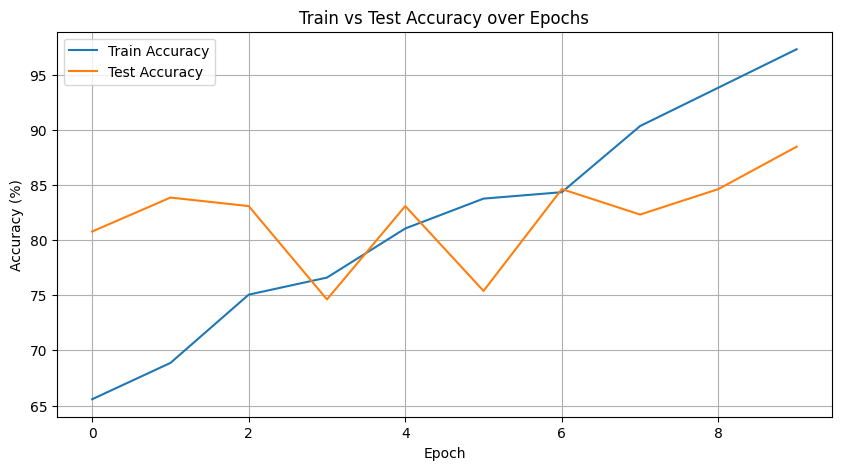

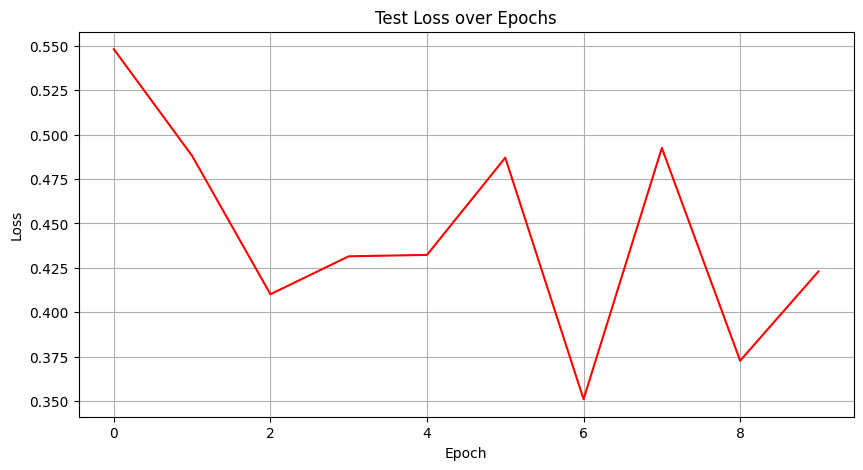


🔍 Final Average Metrics:
  ➤ Average Train Accuracy: 81.66%
  ➤ Average Test Accuracy:  82.08%

📊 Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.94      0.92        88
   malignant       0.86      0.76      0.81        42

    accuracy                           0.88       130
   macro avg       0.88      0.85      0.86       130
weighted avg       0.88      0.88      0.88       130



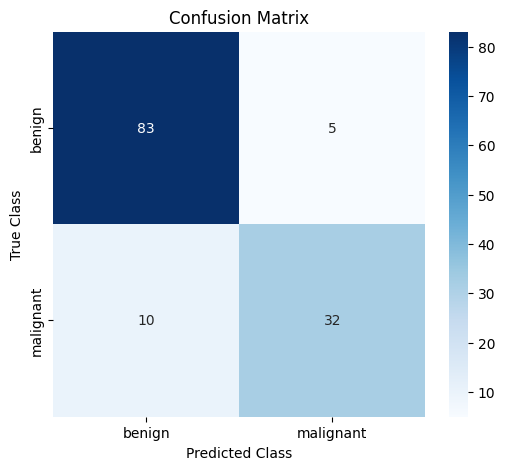

CPU times: user 1min 21s, sys: 3.69 s, total: 1min 25s
Wall time: 5min 3s


In [ ]:
# Model 1 Startified

%%time

import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

# ====== STEP 2: SETUP TRANSFORMS ======
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ====== STEP 3: LOAD DATA WITH STRATIFIED SPLIT ======
dataset = datasets.ImageFolder(root=prepared_path, transform=transform)
labels = [label for _, label in dataset]
train_idx, test_idx = train_test_split(
    list(range(len(dataset))), stratify=labels, test_size=0.2, random_state=42
)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ====== STEP 4: DEFINE CNN MODEL WITH DYNAMIC FLATTENING ======
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)
            flattened_size = self.features(dummy_input).view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# ====== STEP 5: TRAINING SETUP ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ====== STEP 6: TRAIN THE MODEL ======
num_epochs = 10
train_accuracies = []
test_accuracies = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_accuracy = 100 * correct / total
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_accuracies.append(test_accuracy)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, F1: {train_f1:.2f}")
    print(f"  Test  Loss: {avg_test_loss:.4f}, Test  Acc: {test_accuracy:.2f}%, F1: {test_f1:.2f}")

    if epoch == 0 or test_accuracy > max(test_accuracies[:-1]):
        torch.save(model.state_dict(), "/content/drive/MyDrive/CNPRM Workshop/saved_models_binary/model1_best_acc_model_lr1e-3.pt")
        print("💾 Best model saved (test accuracy improved)!\n")
    else:
        print()

# ====== STEP 8: PLOT TRAINING VS. TESTING ACCURACY ======
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses, color='red', label="Test Loss")
plt.title("Test Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ====== STEP 9: FINAL METRICS ======
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_test_acc = sum(test_accuracies) / len(test_accuracies)

print(f"\n🔍 Final Average Metrics:")
print(f"  ➤ Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"  ➤ Average Test Accuracy:  {avg_test_acc:.2f}%")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:")
target_names = dataset.classes
print(classification_report(all_labels, all_preds, target_names=target_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


# Model 2 (CNN Script with Data Augmentation on Minority Class)

Epoch [1/10]
  Train Loss: 0.7190, Train Acc: 67.12%, F1: 0.57
  Test  Loss: 1.0489, Test  Acc: 67.69%, F1: 0.40
📅 Best model saved (test accuracy improved)!

Epoch [2/10]
  Train Loss: 0.6625, Train Acc: 64.22%, F1: 0.57
  Test  Loss: 0.5093, Test  Acc: 83.08%, F1: 0.78
📅 Best model saved (test accuracy improved)!

Epoch [3/10]
  Train Loss: 0.5401, Train Acc: 74.47%, F1: 0.68
  Test  Loss: 0.4593, Test  Acc: 82.31%, F1: 0.78

Epoch [4/10]
  Train Loss: 0.5087, Train Acc: 75.63%, F1: 0.70
  Test  Loss: 0.4484, Test  Acc: 80.00%, F1: 0.72

Epoch [5/10]
  Train Loss: 0.4478, Train Acc: 79.69%, F1: 0.74
  Test  Loss: 0.3977, Test  Acc: 84.62%, F1: 0.82
📅 Best model saved (test accuracy improved)!

Epoch [6/10]
  Train Loss: 0.3373, Train Acc: 82.98%, F1: 0.80
  Test  Loss: 0.4185, Test  Acc: 83.08%, F1: 0.78

Epoch [7/10]
  Train Loss: 0.2596, Train Acc: 89.56%, F1: 0.88
  Test  Loss: 0.4065, Test  Acc: 81.54%, F1: 0.78

Epoch [8/10]
  Train Loss: 0.1355, Train Acc: 94.39%, F1: 0.94
  Te

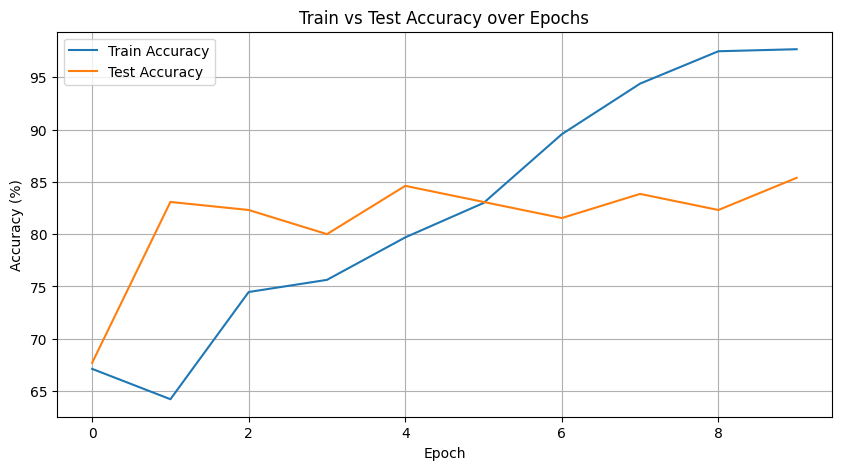

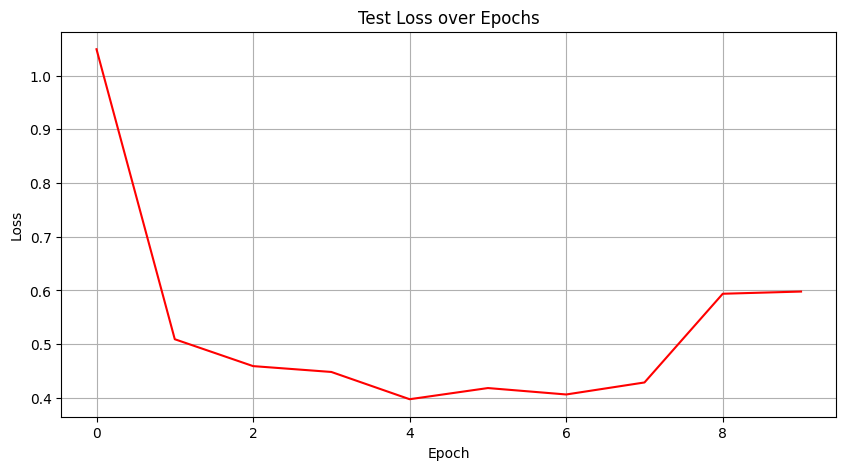


🔍 Final Average Metrics:
  ➤ Average Train Accuracy: 82.32%
  ➤ Average Test Accuracy:  81.38%

📊 Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.91      0.89        88
   malignant       0.79      0.74      0.77        42

    accuracy                           0.85       130
   macro avg       0.84      0.82      0.83       130
weighted avg       0.85      0.85      0.85       130



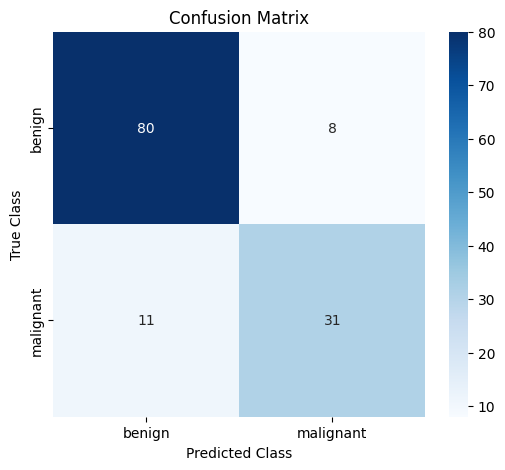

CPU times: user 1min 28s, sys: 3.58 s, total: 1min 32s
Wall time: 2min 2s


In [ ]:
# Model 2 with stratified split

%%time

import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np

torch.manual_seed(42)

# ====== STEP 2: DEFINE CLASS-SPECIFIC TRANSFORMS ====== do some scale data augmentation
augmented_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

non_augmented_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = non_augmented_transform

# ====== STEP 3: LOAD DATA AND APPLY AUGMENTATION TO MINORITY ONLY ======
raw_dataset = datasets.ImageFolder(root=prepared_path, transform=None)
class_to_idx = raw_dataset.class_to_idx
targets = [label for _, label in raw_dataset]
counts = Counter(targets)
minority_class = min(counts, key=counts.get)
majority_class = max(counts, key=counts.get)

minority_indices = [i for i, (_, label) in enumerate(raw_dataset) if label == minority_class]
majority_indices = [i for i, (_, label) in enumerate(raw_dataset) if label == majority_class]

minority_dataset = Subset(raw_dataset, minority_indices)
minority_dataset.dataset.transform = augmented_transform

majority_dataset = Subset(raw_dataset, majority_indices)
majority_dataset.dataset.transform = non_augmented_transform

combined_dataset = ConcatDataset([minority_dataset, majority_dataset])
combined_targets = [targets[i] for i in minority_indices + majority_indices]

train_idx, test_idx = train_test_split(
    list(range(len(combined_dataset))), stratify=combined_targets, test_size=0.2, random_state=42
)
train_subset = Subset(combined_dataset, train_idx)
test_subset = Subset(combined_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

# ====== STEP 4: DEFINE CNN MODEL ======
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)
            flattened_size = self.features(dummy_input).view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# ====== STEP 5: TRAINING SETUP ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ====== STEP 6: TRAIN THE MODEL ======
num_epochs = 10
train_accuracies = []
test_accuracies = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_accuracy = 100 * correct / total
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_accuracies.append(test_accuracy)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, F1: {train_f1:.2f}")
    print(f"  Test  Loss: {avg_test_loss:.4f}, Test  Acc: {test_accuracy:.2f}%, F1: {test_f1:.2f}")

    if epoch == 0 or test_accuracy > max(test_accuracies[:-1]):
        torch.save(model.state_dict(), "/content/drive/MyDrive/CNPRM Workshop/saved_models_binary/model2_best_acc_model_lr1e-3.pt")
        print("📅 Best model saved (test accuracy improved)!\n")
    else:
        print()

# ====== STEP 7: PLOT ACCURACY & LOSS ======
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses, color='red', label="Test Loss")
plt.title("Test Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ====== STEP 8: FINAL METRICS ======
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_test_acc = sum(test_accuracies) / len(test_accuracies)

print(f"\n🔍 Final Average Metrics:")
print(f"  ➤ Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"  ➤ Average Test Accuracy:  {avg_test_acc:.2f}%")

# ====== STEP 9: F1-SCORE & CONFUSION MATRIX ======
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:")
target_names = ['benign', 'malignant']
print(classification_report(all_labels, all_preds, target_names=target_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


# Model 3 (Cross-Validation)

In [ ]:
%%time

import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from collections import Counter

# ====== SETUP ======
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== DEFINE TRANSFORMS ======
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ====== LOAD DATASET WITHOUT TRANSFORM INITIALLY ======
full_dataset = datasets.ImageFolder(root=prepared_path, transform=None)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_targets = [full_dataset[i][1] for i in train_dataset.indices]

# ====== CROSS-VALIDATION SETUP ======
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ====== HYPERPARAMETER SEARCH SPACE ======
learning_rates = [1e-3, 1e-4]
weight_decays = [0.0, 1e-4]
dropout_rates = [0.25, 0.5]
optimizers = ['AdamW', 'Adam', 'SGD']

best_f1 = 0.0
best_model_state = None
best_hparams = ""

# ====== MODEL DEFINITION ======
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)
            flattened_size = self.features(dummy_input).view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ====== HYPERPARAMETER TUNING LOOP ======
for lr in learning_rates:
    for wd in weight_decays:
        for dr in dropout_rates:
            for opt_type in optimizers:
                print(f"Testing: lr={lr}, wd={wd}, dropout={dr}, optimizer={opt_type}")
                fold_f1s = []

                for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
                    model = SimpleCNN(dropout_rate=dr).to(device)
                    if opt_type == 'AdamW':
                        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
                    if opt_type == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    else:
                        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

                    criterion = nn.CrossEntropyLoss()

                    train_indices = [train_dataset.indices[i] for i in train_idx]
                    val_indices = [train_dataset.indices[i] for i in val_idx]

                    train_subset = Subset(full_dataset, train_indices)
                    val_subset = Subset(full_dataset, val_indices)

                    train_subset.dataset.transform = augmented_transform
                    val_subset.dataset.transform = transform

                    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
                    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

                    for epoch in range(10):
                        model.train()
                        for images, labels in train_loader:
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                    model.eval()
                    all_preds, all_labels = [], []
                    with torch.no_grad():
                        for images, labels in val_loader:
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            _, predicted = outputs.max(1)
                            all_preds.extend(predicted.cpu().numpy())
                            all_labels.extend(labels.cpu().numpy())

                    fold_f1 = f1_score(all_labels, all_preds, average='macro')
                    fold_f1s.append(fold_f1)

                avg_f1 = np.mean(fold_f1s)
                print(f"Average F1 across folds: {avg_f1:.4f}")
                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_model_state = model.state_dict()
                    best_hparams = f"lr{lr}_wd{wd}_dr{dr}_opt{opt_type}"
                    print("[INFO] New best model found!\n")


# ====== SAVE BEST MODEL ======
torch.save(best_model_state, f"/content/drive/MyDrive/CNPRM Workshop/saved_models_binary/best_crossval_model_{best_hparams}_v2.pt")
print(f"\nBest F1-score from cross-validation: {best_f1:.4f} with hyperparams: {best_hparams}")


Testing: lr=0.001, wd=0.0, dropout=0.25, optimizer=AdamW
Average F1 across folds: 0.7077
[INFO] New best model found!

Testing: lr=0.001, wd=0.0, dropout=0.25, optimizer=Adam
Average F1 across folds: 0.7371
[INFO] New best model found!

Testing: lr=0.001, wd=0.0, dropout=0.25, optimizer=SGD
Average F1 across folds: 0.6873
Testing: lr=0.001, wd=0.0, dropout=0.5, optimizer=AdamW
Average F1 across folds: 0.6514
Testing: lr=0.001, wd=0.0, dropout=0.5, optimizer=Adam
Average F1 across folds: 0.7705
[INFO] New best model found!

Testing: lr=0.001, wd=0.0, dropout=0.5, optimizer=SGD
Average F1 across folds: 0.7026
Testing: lr=0.001, wd=0.0001, dropout=0.25, optimizer=AdamW
Average F1 across folds: 0.7071
Testing: lr=0.001, wd=0.0001, dropout=0.25, optimizer=Adam
Average F1 across folds: 0.7589
Testing: lr=0.001, wd=0.0001, dropout=0.25, optimizer=SGD
Average F1 across folds: 0.7268
Testing: lr=0.001, wd=0.0001, dropout=0.5, optimizer=AdamW
Average F1 across folds: 0.6239
Testing: lr=0.001, wd

# Model 4 (ResNet-50 pre-trained)

In [ ]:
%%time

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# ====== SETUP ======
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== DEFINE TRANSFORMS ======
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

augmented_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====== LOAD DATASET WITHOUT TRANSFORM INITIALLY ======
full_dataset = datasets.ImageFolder(root=prepared_path, transform=None)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_targets = [full_dataset[i][1] for i in train_dataset.indices]

# ====== CROSS-VALIDATION SETUP ======
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ====== MODEL DEFINITION ======
def get_resnet50_model():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model

# ====== HYPERPARAMETER SEARCH ======
learning_rates = [1e-3, 1e-4]
weight_decays = [0.0, 1e-4]

best_f1 = 0.0
best_hparams = ""
best_lr = None
best_wd = None

# To store models from best hyperparameters
best_models = []

for lr in learning_rates:
    for wd in weight_decays:
        print(f"Testing: lr={lr}, wd={wd}")
        fold_f1s = []
        current_models = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
            model = get_resnet50_model().to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.CrossEntropyLoss()

            train_indices = [train_dataset.indices[i] for i in train_idx]
            val_indices = [train_dataset.indices[i] for i in val_idx]
            train_subset = Subset(full_dataset, train_indices)
            val_subset = Subset(full_dataset, val_indices)
            train_subset.dataset.transform = augmented_transform
            val_subset.dataset.transform = transform

            train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

            # Training loop
            for epoch in range(10):
                model.train()
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            fold_f1 = f1_score(all_labels, all_preds, average='macro')
            fold_f1s.append(fold_f1)

            # Store model state for potential saving
            current_models.append(model.state_dict())

        avg_f1 = np.mean(fold_f1s)
        print(f"Average F1 across folds: {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_lr = lr
            best_wd = wd
            resnet50_best_hparams = f"resnet50_lr{lr}_wd{wd}"
            best_models = current_models  # Save only the best set of models
            print("[INFO] New best hyperparameter set found!\n")

# ====== SAVE BEST MODELS ======
save_dir = "/content/drive/MyDrive/CNPRM Workshop/saved_models_binary"
os.makedirs(save_dir, exist_ok=True)

print(f"\n[RESULT] Best F1-score: {best_f1:.4f} with hyperparams: {resnet50_best_hparams}")
for fold, model_state in enumerate(best_models):
    fold_model_path = os.path.join(save_dir, f"{resnet50_best_hparams}_fold{fold}.pt")
    torch.save(model_state, fold_model_path)
    print(f"✔️ Saved model for fold {fold} to {fold_model_path}")


Testing: lr=0.001, wd=0.0
Average F1 across folds: 0.7653
[INFO] New best hyperparameter set found!

Testing: lr=0.001, wd=0.0001
Average F1 across folds: 0.7284
Testing: lr=0.0001, wd=0.0
Average F1 across folds: 0.6738
Testing: lr=0.0001, wd=0.0001
Average F1 across folds: 0.7008

[RESULT] Best F1-score: 0.7653 with hyperparams: resnet50_lr0.001_wd0.0
✔️ Saved model for fold 0 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/resnet50_lr0.001_wd0.0_fold0.pt
✔️ Saved model for fold 1 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/resnet50_lr0.001_wd0.0_fold1.pt
✔️ Saved model for fold 2 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/resnet50_lr0.001_wd0.0_fold2.pt
✔️ Saved model for fold 3 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/resnet50_lr0.001_wd0.0_fold3.pt
✔️ Saved model for fold 4 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/resnet50_lr0.001_wd0.0_fold4.pt
CPU times: user 18min 40s, sys: 34.4 s, total: 19

Evaluating Fold 1
Evaluating Fold 2
Evaluating Fold 3
Evaluating Fold 4
Evaluating Fold 5

📊 Evaluation Metrics on Test Set:
  ➤ Accuracy:  0.8008
  ➤ Precision: 0.7815
  ➤ Recall:    0.7607
  ➤ F1-score:  0.7689

📄 Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.88      0.85       343
   malignant       0.74      0.64      0.68       174

    accuracy                           0.80       517
   macro avg       0.78      0.76      0.77       517
weighted avg       0.80      0.80      0.80       517



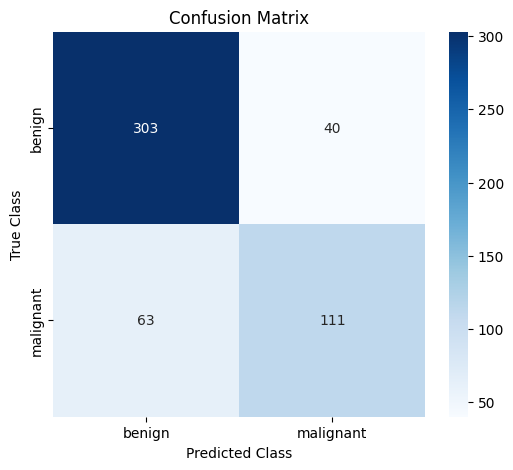

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
from torchvision import models

# Reload best model
def get_resnet50_model():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Redefine test transform
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset.transform = test_transform

# ====== CROSS-VALIDATION SETUP ======
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate on each fold's val set
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
    print(f"Evaluating Fold {fold + 1}")

    model_path = f"/content/drive/MyDrive/CNPRM Workshop/saved_models_binary/{resnet50_best_hparams}_fold{fold}.pt"
    model = get_resnet50_model().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    val_indices = [train_dataset.indices[i] for i in val_idx]
    val_subset = Subset(full_dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


# ====== Metrics ======
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"\n📊 Evaluation Metrics on Test Set:")
print(f"  ➤ Accuracy:  {accuracy:.4f}")
print(f"  ➤ Precision: {precision:.4f}")
print(f"  ➤ Recall:    {recall:.4f}")
print(f"  ➤ F1-score:  {f1:.4f}")

# ====== Classification Report ======
print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# ====== Confusion Matrix ======
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


# Model 5 (VGG-19 pre-trained)

In [ ]:
%%time

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# ====== SETUP ======
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== DEFINE TRANSFORMS ======
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

augmented_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====== LOAD DATASET WITHOUT TRANSFORM INITIALLY ======
full_dataset = datasets.ImageFolder(root=prepared_path, transform=None)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_targets = [full_dataset[i][1] for i in train_dataset.indices]

# ====== CROSS-VALIDATION SETUP ======
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ====== MODEL DEFINITION ======
def get_vgg19_model():
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    return model

# ====== HYPERPARAMETER SEARCH ======
learning_rates = [1e-3, 1e-4]
weight_decays = [0.0, 1e-4]

best_f1 = 0.0
best_hparams = ""
best_lr = None
best_wd = None

# To store models from best hyperparameters
best_models = []

for lr in learning_rates:
    for wd in weight_decays:
        print(f"Testing: lr={lr}, wd={wd}")
        fold_f1s = []
        current_models = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
            model = get_vgg19_model().to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.CrossEntropyLoss()

            train_indices = [train_dataset.indices[i] for i in train_idx]
            val_indices = [train_dataset.indices[i] for i in val_idx]
            train_subset = Subset(full_dataset, train_indices)
            val_subset = Subset(full_dataset, val_indices)
            train_subset.dataset.transform = augmented_transform
            val_subset.dataset.transform = transform

            train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

            # Training loop
            for epoch in range(10):
                model.train()
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            fold_f1 = f1_score(all_labels, all_preds, average='macro')
            fold_f1s.append(fold_f1)

            # Store model state for potential saving
            current_models.append(model.state_dict())

        avg_f1 = np.mean(fold_f1s)
        print(f"Average F1 across folds: {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_lr = lr
            best_wd = wd
            vgg19_best_hparams = f"vgg19_lr{lr}_wd{wd}"
            best_models = current_models  # Save only the best set of models
            print("[INFO] New best hyperparameter set found!\n")

# ====== SAVE BEST MODELS ======
save_dir = "/content/drive/MyDrive/CNPRM Workshop/saved_models_binary"
os.makedirs(save_dir, exist_ok=True)

print(f"\n[RESULT] Best F1-score: {best_f1:.4f} with hyperparams: {vgg19_best_hparams}")
for fold, model_state in enumerate(best_models):
    fold_model_path = os.path.join(save_dir, f"{vgg19_best_hparams}_fold{fold}.pt")
    torch.save(model_state, fold_model_path)
    print(f"✔️ Saved model for fold {fold} to {fold_model_path}")


Testing: lr=0.001, wd=0.0


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 121MB/s]


Average F1 across folds: 0.7762
[INFO] New best hyperparameter set found!

Testing: lr=0.001, wd=0.0001
Average F1 across folds: 0.8218
[INFO] New best hyperparameter set found!

Testing: lr=0.0001, wd=0.0
Average F1 across folds: 0.8194
Testing: lr=0.0001, wd=0.0001
Average F1 across folds: 0.8203

[RESULT] Best F1-score: 0.8218 with hyperparams: vgg19_lr0.001_wd0.0001
✔️ Saved model for fold 0 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/vgg19_lr0.001_wd0.0001_fold0.pt
✔️ Saved model for fold 1 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/vgg19_lr0.001_wd0.0001_fold1.pt
✔️ Saved model for fold 2 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/vgg19_lr0.001_wd0.0001_fold2.pt
✔️ Saved model for fold 3 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/vgg19_lr0.001_wd0.0001_fold3.pt
✔️ Saved model for fold 4 to /content/drive/MyDrive/CNPRM Workshop/saved_models_binary/vgg19_lr0.001_wd0.0001_fold4.pt
CPU times: user 18min 20s, sys: 

Evaluating Fold 1
Evaluating Fold 2
Evaluating Fold 3
Evaluating Fold 4
Evaluating Fold 5

📊 Evaluation Metrics on Test Set:
  ➤ Accuracy:  0.8356
  ➤ Precision: 0.8146
  ➤ Recall:    0.8336
  ➤ F1-score:  0.8218

📄 Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.84      0.87       343
   malignant       0.72      0.83      0.77       174

    accuracy                           0.84       517
   macro avg       0.81      0.83      0.82       517
weighted avg       0.84      0.84      0.84       517



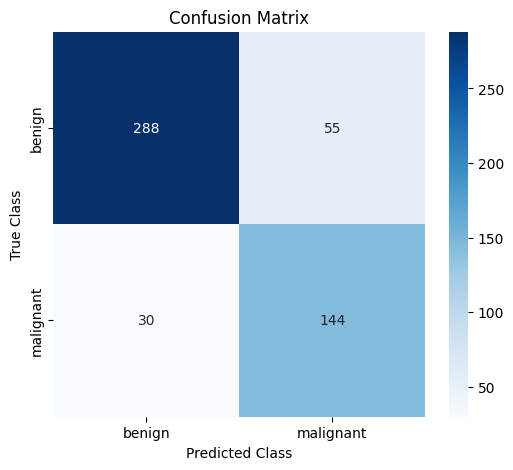

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
from torchvision import models

# Reload best model
def get_vgg19_model():
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
    return model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Redefine test transform
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset.transform = test_transform

# ====== CROSS-VALIDATION SETUP ======
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate on each fold's val set
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
    print(f"Evaluating Fold {fold + 1}")

    model_path = f"/content/drive/MyDrive/CNPRM Workshop/saved_models_binary/{vgg19_best_hparams}_fold{fold}.pt"
    model = get_vgg19_model().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    val_indices = [train_dataset.indices[i] for i in val_idx]
    val_subset = Subset(full_dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


# ====== Metrics ======
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"\n📊 Evaluation Metrics on Test Set:")
print(f"  ➤ Accuracy:  {accuracy:.4f}")
print(f"  ➤ Precision: {precision:.4f}")
print(f"  ➤ Recall:    {recall:.4f}")
print(f"  ➤ F1-score:  {f1:.4f}")

# ====== Classification Report ======
print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# ====== Confusion Matrix ======
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
